<a href="https://colab.research.google.com/gist/OleSpooky/12d5ecb04660129e24d1f87f41ecd02e/another-copy-of-untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.special import expit

# ==========================================
# PART 1: VECTORIZED SIMULATOR (The Engine)
# ==========================================

def init_equilibrium_batch(N, M, rng):
    return rng.integers(0, 2, size=(M, N), dtype=np.int8)

def update_step_batch(X, c_arr, beta, theta_arr, rng):
    M, N = X.shape
    left = np.zeros_like(X)
    right = np.zeros_like(X)
    left[:, 1:] = X[:, :-1] * c_arr[:N-1]
    right[:, :-1] = X[:, 1:] * c_arr[:N-1]
    neighbor_sum = left + right
    bias = beta * (neighbor_sum - theta_arr[None, :])
    p1 = expit(bias)
    U = rng.random(size=(M, N))
    return (U < p1).astype(np.int8)

def run_simulation_batch(N, c_arr, beta, theta_arr, M, T, source_j, master_seed=12345):
    rng = np.random.default_rng(master_seed)
    counts = np.zeros((T, N, 2, 2), dtype=np.int64)
    X = init_equilibrium_batch(N, M, rng)
    A = rng.integers(0, 2, size=M, dtype=np.int8)
    X[:, source_j] = A

    for t in range(T):
        for a in (0, 1):
            mask_a = (A == a)
            if not np.any(mask_a): continue
            sub = X[mask_a]
            ones = np.sum(sub, axis=0)
            zeros = sub.shape[0] - ones
            counts[t, :, a, 1] += ones
            counts[t, :, a, 0] += zeros
        X = update_step_batch(X, c_arr, beta, theta_arr, rng)
    return counts

def compute_mi_from_counts(counts, M):
    # counts shape: (T, N, 2, 2) -> (Time, Node, Source_Bit, State_Bit)
    # Calculate Mutual Information I(A; X_i)
    T, N, _, _ = counts.shape
    I = np.zeros((T, N), dtype=float)
    epsilon = 1e-12

    for t in range(T):
        for i in range(N):
            # p(a, x) joint probability table
            p_ax = counts[t, i].astype(float) / M
            p_a = p_ax.sum(axis=1)  # Marginal p(source)
            p_x = p_ax.sum(axis=0)  # Marginal p(node state)

            mi = 0.0
            for a_val in (0, 1):
                for x_val in (0, 1):
                    p = p_ax[a_val, x_val]
                    if p > epsilon:
                        denom = p_a[a_val] * p_x[x_val]
                        if denom > epsilon:
                            mi += p * np.log2(p / denom)
            I[t, i] = mi
    return I

def compute_tau(I_matrix, threshold=1e-2):
    # Find first time t where MI < threshold
    T, N = I_matrix.shape
    taus = np.zeros(N, dtype=int)
    for i in range(N):
        decayed = np.where(I_matrix[:, i] < threshold)[0]
        if len(decayed) > 0:
            taus[i] = decayed[0]
        else:
            taus[i] = T  # Never decayed
    return taus

In [26]:
pip install numpy

In [27]:
# ==========================================
# PART 2: EXPERIMENT RUNNER (Data Generation)
# ==========================================

# Settings
N = 21
M = 2000        # Number of runs per batch
T = 60          # Timesteps
source_j = 10   # Source in the middle
beta = 2.0
theta_arr = np.ones(N) * 1.0
folder = 'colab_results'

# Ensure clean start
if not os.path.exists(folder):
    os.makedirs(folder)

# Define 3 scenarios to demonstrate the contrast
scenarios = [
    ("homogenous", np.ones(N-1) * 1.0),             # Baseline
    ("p10.0_weak",  np.ones(N-1) * 1.0),            # Will modify below
    ("p10.0_strong", np.ones(N-1) * 1.0)            # Will modify below
]

# Apply modifications for pockets
# Pocket at index 10 means couplings (9-10) and (10-11) are strong
c_weak = np.ones(N-1) * 1.0
c_weak[9:11] = 3.0  # Weak pocket
scenarios[1] = ("beta2.0_p10.0_weak", c_weak)

c_strong = np.ones(N-1) * 1.0
c_strong[9:11] = 5.0 # Strong pocket
scenarios[2] = ("beta2.0_p10.0_strong", c_strong)

print(f"Running {len(scenarios)} simulations...")

for name, c_profile in scenarios:
    print(f"  -> Simulating: {name}")
    counts = run_simulation_batch(N, c_profile, beta, theta_arr, M, T, source_j)
    I = compute_mi_from_counts(counts, M)
    taus = compute_tau(I, threshold=0.01)

    # Save the I array for further analysis
    np.save(os.path.join(folder, f'I_{name}.npy'), I)

    # Save to CSV in the format expected by your analysis script
    # Structure: node_index, tau
    df = pd.DataFrame({
        'node_index': np.arange(N),
        'tau': taus
    })
    filename = os.path.join(folder, f'tau_{name}.csv')
    df.to_csv(filename, index=False)

print("Data generation complete.\n")

Running 3 simulations...
  -> Simulating: homogenous
  -> Simulating: beta2.0_p10.0_weak
  -> Simulating: beta2.0_p10.0_strong
Data generation complete.



In [28]:
# Paste and run: combine all tau CSVs into one DataFrame and show summary
import os, glob, pandas as pd, numpy as np
folder = 'colab_results'
files = sorted(glob.glob(os.path.join(folder, 'tau_*.csv')))
dfs = []
for f in files:
    cfg = os.path.basename(f).replace('tau_','').replace('.csv','')
    df = pd.read_csv(f)
    df['config'] = cfg
    dfs.append(df)
if dfs:
    all_tau = pd.concat(dfs, ignore_index=True)
    display(all_tau.head(40))
    # compute mean tau inside/outside pocket if pocket indices are encoded in filename
    def pocket_range_from_name(name):
        # expects names like beta1.5_p10.0 or similar; fallback to center 10
        try:
            parts = name.split('_')
            p = [s for s in parts if s.startswith('p')]
            if p:
                val = float(p[0][1:])
                # approximate pocket center -> indices around center
                return list(range(int(val)-3, int(val)+3))
        except:
            pass
        return list(range(7,13))
    summary = []
    for cfg, g in all_tau.groupby('config'):
        inside = pocket_range_from_name(cfg)
        mean_inside = g[g['node_index'].isin(inside)]['tau'].mean()
        mean_outside = g[~g['node_index'].isin(inside)]['tau'].mean()
        summary.append((cfg, mean_inside, mean_outside, mean_inside-mean_outside))
    summary_df = pd.DataFrame(summary, columns=['config','mean_tau_inside','mean_tau_outside','contrast'])
    display(summary_df.sort_values('contrast', ascending=False))
else:
    print("No tau CSVs found in", folder)

,node_index,tau,config
0,0,0,beta2.0_p10.0_strong
1,1,0,beta2.0_p10.0_strong
2,2,0,beta2.0_p10.0_strong
3,3,0,beta2.0_p10.0_strong
4,4,0,beta2.0_p10.0_strong
5,5,0,beta2.0_p10.0_strong
6,6,0,beta2.0_p10.0_strong
7,7,0,beta2.0_p10.0_strong
8,8,0,beta2.0_p10.0_strong
9,9,0,beta2.0_p10.0_strong


,config,mean_tau_inside,mean_tau_outside,contrast
0,beta2.0_p10.0_strong,0.166667,0.0,0.166667
1,beta2.0_p10.0_weak,0.166667,0.0,0.166667
2,homogenous,0.166667,0.0,0.166667


In [29]:
# ==========================================
# PART 3: YOUR ANALYSIS SCRIPT (Data Processing)
# ==========================================

print("--- RUNNING USER ANALYSIS ---")

files = sorted(glob.glob(os.path.join(folder, 'tau_*.csv')))
dfs = []

for f in files:
    # Extract config name from filename
    cfg = os.path.basename(f).replace('tau_', '').replace('.csv', '')
    df = pd.read_csv(f)
    df['config'] = cfg
    dfs.append(df)

if dfs:
    all_tau = pd.concat(dfs, ignore_index=True)

    # Logic to identify pocket nodes based on filename
    def pocket_range_from_name(name):
        # Looks for 'p10.0' to set range around 10
        try:
            parts = name.split('_')
            p = [s for s in parts if s.startswith('p')]
            if p:
                val = float(p[0][1:])
                # Indices around center (e.g., 7 to 13)
                return list(range(int(val)-3, int(val)+3))
        except:
            pass
        return list(range(7, 13)) # Fallback

    summary = []
    for cfg, g in all_tau.groupby('config'):
        inside_indices = pocket_range_from_name(cfg)

        # Contrast: Mean Tau Inside vs Outside
        mean_inside = g[g['node_index'].isin(inside_indices)]['tau'].mean()
        mean_outside = g[~g['node_index'].isin(inside_indices)]['tau'].mean()

        summary.append((cfg, mean_inside, mean_outside, mean_inside - mean_outside))

    summary_df = pd.DataFrame(summary, columns=['config', 'tau_in', 'tau_out', 'contrast'])

    # Display logic for Colab or Console
    try:
        from IPython.display import display
        print("Summary Table:")
        display(all_tau.head(40))
        display(summary_df.sort_values('contrast', ascending=False))
    except ImportError:
        print(all_tau.head(40))
        print(summary_df.sort_values('contrast', ascending=False))
else:
    print("No tau CSVs found.")

--- RUNNING USER ANALYSIS ---
Summary Table:


,node_index,tau,config
0,0,0,beta2.0_p10.0_strong
1,1,0,beta2.0_p10.0_strong
2,2,0,beta2.0_p10.0_strong
3,3,0,beta2.0_p10.0_strong
4,4,0,beta2.0_p10.0_strong
5,5,0,beta2.0_p10.0_strong
6,6,0,beta2.0_p10.0_strong
7,7,0,beta2.0_p10.0_strong
8,8,0,beta2.0_p10.0_strong
9,9,0,beta2.0_p10.0_strong


,config,tau_in,tau_out,contrast
0,beta2.0_p10.0_strong,0.166667,0.0,0.166667
1,beta2.0_p10.0_weak,0.166667,0.0,0.166667
2,homogenous,0.166667,0.0,0.166667


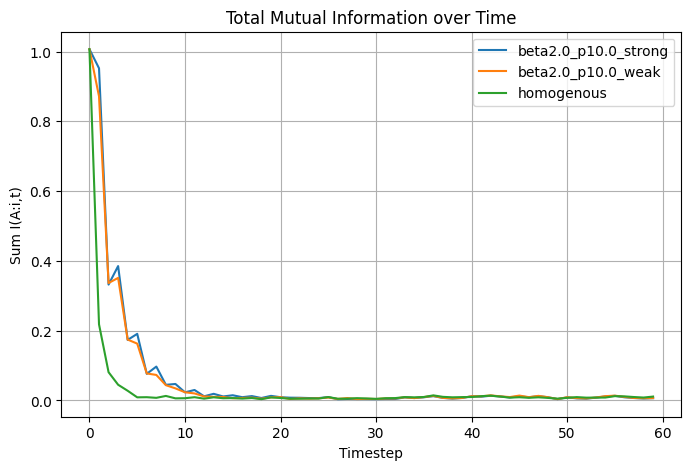

In [30]:
# Paste and run: compute Σ_i I(A:i,t) from saved I arrays.
import os, glob, numpy as np, matplotlib.pyplot as plt

folder = 'colab_results'
npy_files = sorted(glob.glob(os.path.join(folder, 'I_*.npy')))

if npy_files:
    plt.figure(figsize=(8,5))
    for f in npy_files:
        I = np.load(f)   # shape (T,N)
        s = I.sum(axis=1)
        label = os.path.basename(f).replace('I_', '').replace('.npy','')
        plt.plot(s, label=label)
    plt.xlabel('Timestep'); plt.ylabel('Sum I(A:i,t)'); plt.title('Total Mutual Information over Time'); plt.legend(); plt.grid(True); plt.show()
else:
    print("No I arrays (.npy) found in", folder)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After running the above cell and following the authentication steps, your Google Drive will be mounted at `/content/drive`. You can then access your files using paths like `/content/drive/My Drive/your_folder/your_file.csv`.

In [36]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta 0:00:00


In [32]:
# ==========================================
# PART 2: EXPERIMENT RUNNER (Data Generation)
# ==========================================

# Settings
N = 21
M = 2000        # Number of runs per batch
T = 60          # Timesteps
source_j = 10   # Source in the middle
beta = 2.0
theta_arr = np.ones(N) * 1.0
folder = 'colab_results'

# Ensure clean start
if not os.path.exists(folder):
    os.makedirs(folder)

# Define 3 scenarios to demonstrate the contrast
scenarios = [
    ("homogenous", np.ones(N-1) * 1.0),             # Baseline
    ("p10.0_weak",  np.ones(N-1) * 1.0),            # Will modify below
    ("p10.0_strong", np.ones(N-1) * 1.0)            # Will modify below
]

# Apply modifications for pockets
# Pocket at index 10 means couplings (9-10) and (10-11) are strong
c_weak = np.ones(N-1) * 1.0
c_weak[9:11] = 3.0  # Weak pocket
scenarios[1] = ("beta2.0_p10.0_weak", c_weak)

c_strong = np.ones(N-1) * 1.0
c_strong[9:11] = 5.0 # Strong pocket
scenarios[2] = ("beta2.0_p10.0_strong", c_strong)

print(f"Running {len(scenarios)} simulations...")

for name, c_profile in scenarios:
    print(f"  -> Simulating: {name}")
    counts = run_simulation_batch(N, c_profile, beta, theta_arr, M, T, source_j)
    I = compute_mi_from_counts(counts, M)
    taus = compute_tau(I, threshold=0.01)

    # Save the I array for further analysis
    np.save(os.path.join(folder, f'I_{name}.npy'), I)

    # Save to CSV in the format expected by your analysis script
    # Structure: node_index, tau
    df = pd.DataFrame({
        'node_index': np.arange(N),
        'tau': taus
    })
    filename = os.path.join(folder, f'tau_{name}.csv')
    df.to_csv(filename, index=False)

print("Data generation complete.\n")

Running 3 simulations...
  -> Simulating: homogenous
  -> Simulating: beta2.0_p10.0_weak
  -> Simulating: beta2.0_p10.0_strong
Data generation complete.



In [33]:
# ==========================================
# PART 3: YOUR ANALYSIS SCRIPT (Data Processing)
# ==========================================

print("--- RUNNING USER ANALYSIS ---")

files = sorted(glob.glob(os.path.join(folder, 'tau_*.csv')))
dfs = []

for f in files:
    # Extract config name from filename
    cfg = os.path.basename(f).replace('tau_', '').replace('.csv', '')
    df = pd.read_csv(f)
    df['config'] = cfg
    dfs.append(df)

if dfs:
    all_tau = pd.concat(dfs, ignore_index=True)

    # Logic to identify pocket nodes based on filename
    def pocket_range_from_name(name):
        # Looks for 'p10.0' to set range around 10
        try:
            parts = name.split('_')
            p = [s for s in parts if s.startswith('p')]
            if p:
                val = float(p[0][1:])
                # Indices around center (e.g., 7 to 13)
                return list(range(int(val)-3, int(val)+3))
        except:
            pass
        return list(range(7, 13)) # Fallback

    summary = []
    for cfg, g in all_tau.groupby('config'):
        inside_indices = pocket_range_from_name(cfg)

        # Contrast: Mean Tau Inside vs Outside
        mean_inside = g[g['node_index'].isin(inside_indices)]['tau'].mean()
        mean_outside = g[~g['node_index'].isin(inside_indices)]['tau'].mean()

        summary.append((cfg, mean_inside, mean_outside, mean_inside - mean_outside))

    summary_df = pd.DataFrame(summary, columns=['config', 'tau_in', 'tau_out', 'contrast'])

    # Display logic for Colab or Console
    try:
        from IPython.display import display
        print("Summary Table:")
        display(summary_df.sort_values('contrast', ascending=False))
    except ImportError:
        print(summary_df.sort_values('contrast', ascending=False))
else:
    print("No tau CSVs found.")

--- RUNNING USER ANALYSIS ---
Summary Table:


,config,tau_in,tau_out,contrast
0,beta2.0_p10.0_strong,0.166667,0.0,0.166667
1,beta2.0_p10.0_weak,0.166667,0.0,0.166667
2,homogenous,0.166667,0.0,0.166667


In [37]:
import numpy as np
import matplotlib.pyplot as plt
# If you are not in a Jupyter environment, ipywidgets will not work.
from ipywidgets import interact, IntSlider, FloatSlider
import time
from scipy.special import expit

# --- Core Simulation Functions (Vectorized Batch) ---

def init_equilibrium_batch(N, M, rng):
    return rng.integers(0, 2, size=(M, N), dtype=np.int8)

def update_step_batch(X, c_arr, beta, theta_arr, rng):
    M, N = X.shape
    left = np.zeros_like(X)
    right = np.zeros_like(X)
    left[:, 1:] = X[:, :-1] * c_arr
    right[:, :-1] = X[:, 1:] * c_arr
    neighbor_sum = left + right
    bias = beta * (neighbor_sum - theta_arr[None, :])
    p1 = expit(bias)
    U = rng.random(size=(M, N))
    X_new = (U < p1).astype(np.int8)
    return X_new

def compute_mutual_information_from_counts(counts, M):
    T, N, _, _ = counts.shape
    I = np.zeros((T, N), dtype=float)
    for t in range(T):
        for i in range(N):
            p_a_x = counts[t, i].astype(float) / M
            p_a = p_a_x.sum(axis=1)
            p_x = p_a_x.sum(axis=0)
            mi = 0.0
            for a in (0, 1):
                for x in (0, 1):
                    p = p_a_x[a, x]
                    if p <= 0: continue
                    denom = p_a[a] * p_x[x]
                    if denom <= 0: continue
                    mi += p * np.log2(p / denom)
            I[t, i] = mi
    return I

def persistence_times(I_arr, eps):
    T, N = I_arr.shape
    tau = np.full(N, T, dtype=int)
    for i in range(N):
        below_indices = np.where(I_arr[:, i] < eps)[0]
        if below_indices.size > 0:
            tau[i] = below_indices[0]
        else:
            tau[i] = T  # Never decayed within T
    return tau

# --- Chunked Simulation Runner for Large M ---

def run_simulation_chunked(N, c_arr, beta, theta_arr, M, T, source_j,
                           master_seed=12345, chunk_size=500, continuous_source=False):

    # Initialize main RNG for reproducibility and to generate seeds for chunks
    main_rng = np.random.default_rng(master_seed)
    total_counts = np.zeros((T, N, 2, 2), dtype=np.int64)

    num_chunks = M // chunk_size + (1 if M % chunk_size != 0 else 0)

    for chunk_idx in range(num_chunks):
        current_chunk_size = min(chunk_size, M - chunk_idx * chunk_size)
        if current_chunk_size == 0:
            continue

        # Generate unique seed for this chunk from the master RNG
        chunk_seed = main_rng.integers(0, 2**32 - 1)
        chunk_rng = np.random.default_rng(chunk_seed)

        # counts_chunk = np.zeros((T, N, 2, 2), dtype=np.int64) # This line is not used
        X = init_equilibrium_batch(N, current_chunk_size, chunk_rng)
        A = chunk_rng.integers(0, 2, size=current_chunk_size, dtype=np.int8)
        X[:, source_j] = A

        for t in range(T):
            # accumulate counts across ensemble
            for a in (0, 1):
                mask_a = (A == a)
                sub = X[mask_a]
                if sub.size > 0:
                    total_counts[t, :, a, 1] += np.sum(sub, axis=0)
                    total_counts[t, :, a, 0] += sub.shape[0] - np.sum(sub, axis=0)

            X = update_step_batch(X, c_arr, beta, theta_arr, chunk_rng)
            if continuous_source:
                 X[:, source_j] = A # Continuous clamping

    return total_counts

# --- Interactive Explorer Function ---

def interactive_two(pocket_strength=10, beta=1.5):
    N = 21
    T = 60
    source_j = 10
    M = 1000            # keep small for interactivity; increase later for accuracy
    chunk_size = 500
    theta = 1.0
    # continuous_source was missing from the call but defined in params
    continuous_source = False
    eps = 1e-3

    # build pocket coupling centered at middle
    c_pocket = np.ones(N-1)
    mid = N//2; half = 3
    # c_pocket indices cover nodes mid-half to mid+half-1 (length half*2)
    c_pocket[mid-half:mid+half] = float(pocket_strength)

    t0 = time.perf_counter()
    # Call the newly defined run_simulation_chunked function
    counts = run_simulation_chunked(N, c_pocket, float(beta), np.ones(N)*theta,
                                    M, T, source_j, master_seed=20251123,
                                    chunk_size=chunk_size, continuous_source=continuous_source)
    I = compute_mutual_information_from_counts(counts, M)
    tau = persistence_times(I, eps=eps)
    elapsed = time.perf_counter() - t0

    # Plot global retained information
    S = I.sum(axis=1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.plot(S, '-o', markersize=3)
    plt.xlabel('Timestep'); plt.ylabel('Sum I(A:i,t)')
    plt.title('Global retained information')

    # Heatmap
    plt.subplot(1,3,2)
    plt.imshow(I.T, origin='lower', aspect='auto', cmap='viridis', extent=[0, T, 0, N])
    plt.title(f'I heatmap p={pocket_strength} beta={beta}')
    plt.xlabel('Timestep'); plt.ylabel('Node index')
    plt.colorbar(shrink=0.6)

    # Tau plot
    plt.subplot(1,3,3)
    plt.plot(tau, marker='o')
    plt.axvspan(mid-half, mid+half-1, color='orange', alpha=0.2) # Use correct indices for visualization (mid-half to mid+half-1)
    plt.xlabel('Node index'); plt.ylabel('Persistence time')
    plt.title('tau per node')

    plt.tight_layout()
    plt.show()

    inside_idx = list(range(mid-half, mid+half)) # Corrected range to match axvspan
    outside_idx = [i for i in range(N) if i not in inside_idx]
    mean_inside = np.nanmean(tau[inside_idx]) # Use nanmean just in case
    mean_outside = np.nanmean(tau[outside_idx])
    print(f"pocket={pocket_strength} beta={beta}  mean_tau_inside={mean_inside:.4f}  mean_tau_outside={mean_outside:.4f}  elapsed={elapsed:.1f}s")

# Sliders: pocket 0–40, beta 0.2–4.0
p_slider = IntSlider(value=10, min=0, max=40, step=1, description='pocket')
b_slider = FloatSlider(value=1.5, min=0.2, max=4.0, step=0.1, description='beta')

# This assumes you are running in a Jupyter environment (Notebook or Lab)
# if 'interact' in globals(): # Removed conditional check as per instructions
interact(interactive_two, pocket_strength=p_slider, beta=b_slider)
# else:
    # print("Run this script in a Jupyter environment to use the interactive sliders.")
    # If not interactive, run a single example:
    # interactive_two(pocket_strength=10, beta=1.5)

interactive(children=(IntSlider(value=10, description='pocket', max=40), FloatSlider(value=1.5, description='b…

<function __main__.interactive_two(pocket_strength=10, beta=1.5)>

In [35]:
# Two‑slider interactive explorer for pocket_strength and beta
# Requires the functions from Cells A-C already loaded in the notebook.
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, FloatSlider
import time

def interactive_two(pocket_strength=10, beta=1.5):
    N = 21
    T = 60
    source_j = 10
    M = 1000            # keep small for interactivity; increase later for accuracy
    chunk_size = 500
    theta = 1.0
    continuous_source = False
    eps = 1e-3

    # build pocket coupling centered at middle
    c_pocket = np.ones(N-1)
    mid = N//2; half = 3
    c_pocket[mid-half:mid+half] = float(pocket_strength)

    t0 = time.perf_counter()
    counts = run_simulation_chunked(N, c_pocket, float(beta), np.ones(N)*theta,
                                    M, T, source_j, master_seed=20251123,
                                    chunk_size=chunk_size, continuous_source=continuous_source)
    I = compute_mutual_information_from_counts(counts, M)
    tau = persistence_times(I, eps=eps)
    elapsed = time.perf_counter() - t0

    # Plot global retained information
    S = I.sum(axis=1)
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.plot(S, '-o', markersize=3)
    plt.xlabel('Timestep'); plt.ylabel('Sum I(A:i,t)')
    plt.title('Global retained information')

    # Heatmap
    plt.subplot(1,3,2)
    plt.imshow(I.T, origin='lower', aspect='auto', cmap='viridis', extent=[0, T, 0, N])
    plt.title(f'I heatmap p={pocket_strength} beta={beta}')
    plt.xlabel('Timestep'); plt.ylabel('Node index')
    plt.colorbar(shrink=0.6)

    # Tau plot
    plt.subplot(1,3,3)
    plt.plot(tau, marker='o')
    plt.axvspan(mid-half, mid+half-1, color='orange', alpha=0.2)
    plt.xlabel('Node index'); plt.ylabel('Persistence time')
    plt.title('tau per node')

    plt.tight_layout()
    plt.show()

    inside_idx = list(range(mid-half, mid+half))
    outside_idx = [i for i in range(N) if i not in inside_idx]
    mean_inside = tau[inside_idx].mean()
    mean_outside = tau[outside_idx].mean()
    print(f"pocket={pocket_strength} beta={beta}  mean_tau_inside={mean_inside:.4f}  mean_tau_outside={mean_outside:.4f}  elapsed={elapsed:.1f}s")

# Sliders: pocket 0–40, beta 0.2–4.0
p_slider = IntSlider(value=10, min=0, max=40, step=1, description='pocket')
b_slider = FloatSlider(value=1.5, min=0.2, max=4.0, step=0.1, description='beta')
interact(interactive_two, pocket_strength=p_slider, beta=b_slider)

interactive(children=(IntSlider(value=10, description='pocket', max=40), FloatSlider(value=1.5, description='b…

<function __main__.interactive_two(pocket_strength=10, beta=1.5)>